In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hastikhajeh","key":"00c3342ee065c1db15dce99f2fe07399"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

 94% 233M/247M [00:01<00:00, 149MB/s]
100% 247M/247M [00:02<00:00, 126MB/s]


In [ ]:
!unzip satellite-images-of-water-bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [ ]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os
import albumentations as A
from sklearn.model_selection import train_test_split

In [ ]:
show = True

In [ ]:
class Generator:
    """Generator class for processing the images and the masks for SAM fine-tuning."""

    def __init__(self, dataset_path, image_paths, label_paths, processor, transform=None):
        self.dataset_path = dataset_path
        # self.image_paths = sorted(glob.glob(os.path.join(self.dataset_path, "Images/*.jpg")))
        # self.label_paths = sorted(glob.glob(os.path.join(self.dataset_path, "Masks/*.jpg")))

        self.image_paths = image_paths
        self.label_paths = label_paths

        self.processor = processor
        self.transform = transform


    def __call__(self):
        show = True
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image1 = np.array(Image.open(image_path).resize((256, 256)))
            ground_truth_mask = np.array(Image.open(label_path).convert('L').resize((256, 256)))

            if self.transform:
                augmented = self.transform(image=np.array(image1), mask=np.array(ground_truth_mask))
                image, ground_truth_mask = augmented['image'], augmented['mask']
                if show:
                    # Convert the images to numpy arrays and normalize
                    sample_image_array = img_to_array(image) / 255.0
                    sample_mask_array = img_to_array(image1) / 255.0

                    # Display the sample image and mask
                    plt.figure(figsize=(6, 3))
                    plt.subplot(1, 2, 1)
                    plt.imshow(sample_image_array)
                    plt.title('Sample Satellite Image')
                    plt.subplot(1, 2, 2)
                    plt.imshow(sample_mask_array)
                    plt.title('Corresponding augmented image')
                    plt.show()
                    show = False

            # Get bounding box prompt
            prompt = self.get_bounding_box(ground_truth_mask)

            # Prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs["ground_truth_mask"] = ground_truth_mask

            yield inputs

    def get_bounding_box(self, ground_truth_map):
        #print(ground_truth_map.shape, type(ground_truth_map))
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)

        # Check if there are valid indices
        if len(x_indices) > 0 and len(y_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            # add perturbation to bounding box coordinates
            H, W = ground_truth_map.shape
            x_min = max(0, x_min - np.random.randint(0, 20))
            x_max = min(W, x_max + np.random.randint(0, 20))
            y_min = max(0, y_min - np.random.randint(0, 20))
            y_max = min(H, y_max + np.random.randint(0, 20))
            bbox = [x_min, y_min, x_max, y_max]
        else:
            # If no valid indices found, set default bounding box
            bbox = [0, 0, 0, 0]  # Set default values

        return bbox

In [ ]:
model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/375M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
dataset_path = 'Water Bodies Dataset'

In [ ]:
image_paths = sorted(glob.glob(os.path.join(dataset_path, "Images/*.jpg")))
label_paths = sorted(glob.glob(os.path.join(dataset_path, "Masks/*.jpg")))

# Split the dataset into training and validation sets (90% train, 10% validation)
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, label_paths, test_size=0.1, random_state=42)


In [ ]:
# Define the output signature of the generator class.
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}

transform = A.Compose([
    # Add desired transformations here. For example:
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # Add more transformations as needed
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Prepare the dataset object.
train_dataset_gen = Generator(dataset_path, train_images, train_masks, processor, transform=transform)
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)

test_dataset_gen = Generator(dataset_path, test_images, test_masks, processor, transform=transform)
test_ds = tf.data.Dataset.from_generator(
    test_dataset_gen, output_signature=output_signature
)

In [ ]:
auto = tf.data.AUTOTUNE
batch_size = 2
shuffle_buffer = 4


train_ds = (
    train_ds
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)

test_ds = (
    test_ds
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)

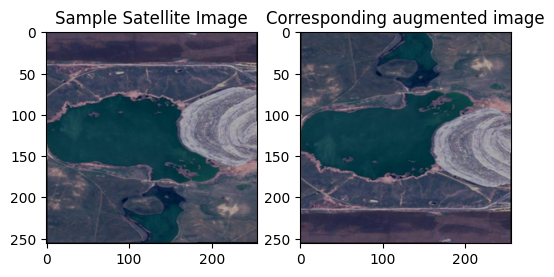

pixel_values (2, 3, 1024, 1024) <dtype: 'float32'> True
original_sizes (2, 2) <dtype: 'int64'> True
reshaped_input_sizes (2, 2) <dtype: 'int64'> True
input_boxes (2, 1, 4) <dtype: 'float64'> True
ground_truth_mask (2, 256, 256) <dtype: 'int32'> True


In [ ]:
sample = next(iter(train_ds))
for k in sample:
    print(k, sample[k].shape, sample[k].dtype, isinstance(sample[k], tf.Tensor))

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    if batch_size > 1:
        # reducing spatial dimensions and batch
        reduce_axis = [0] + reduce_axis
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)
    denominator = ground_o + pred_o
    # calculate DICE coefficient
    loss = 1.0 - (2.0 * intersection + 1e-5) / (denominator + 1e-5)
    loss = tf.reduce_mean(loss)

    return loss

In [ ]:
# initialize SAM model and optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-base")
optimizer = keras.optimizers.Adam(1e-5)

for layer in sam.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False

def calculate_iou(prediction, target):
    # Convert the tensors to boolean type
    prediction = tf.cast(prediction, dtype=tf.bool)
    target = tf.cast(target, dtype=tf.bool)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(target, prediction), dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(target, prediction), dtype=tf.float32))
    iou = intersection / union
    return iou

def calculate_dice_coefficient(prediction, target):
    # Convert the tensors to boolean type
    prediction = tf.cast(prediction, dtype=tf.bool)
    target = tf.cast(target, dtype=tf.bool)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(target, prediction), dtype=tf.float32))
    dice_coefficient = (2.0 * intersection) / (tf.reduce_sum(tf.cast(target, dtype=tf.float32))
                        + tf.reduce_sum(tf.cast(prediction, dtype=tf.float32)))
    return dice_coefficient


@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # pass inputs to SAM model
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=True,
        )

        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # calculate loss over predicted and ground truth masks
        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        iou = calculate_iou(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        dice = calculate_dice_coefficient(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # update trainable variables
        trainable_vars = sam.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))

        return loss, dice, iou

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [ ]:
# run training
for epoch in range(3):
    for inputs in train_ds:
        loss, dice, iou = train_step(inputs)
    print(f"Epoch {epoch + 1}: Loss = {loss:.4f}, Dice = {dice:.4f}, IoU = {iou:.4f}")

Epoch 1: Loss = 0.9920, Dice = 0.7443, IoU = 0.5927
Epoch 2: Loss = 0.9921, Dice = 0.6705, IoU = 0.5043
Epoch 3: Loss = 0.9920, Dice = 0.6874, IoU = 0.5237


In [ ]:
@tf.function
def evaluate_model(dataset):
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    num_batches = 0.0

    for batch in dataset:
        # Perform inference using the model
        inputs = batch  # Modify this if you need to preprocess inputs
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=False,
        )
        # outputs = sam(inputs, training=False)  # Set training=False for inference

        # Extract relevant tensors (predicted and ground truth)
        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # Calculate loss, Dice coefficient, and IoU
        # loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # iou = calculate_iou(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # dice = calculate_dice_coefficient(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        iou = calculate_iou(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        dice = calculate_dice_coefficient(tf.expand_dims(ground_truth_masks, 1), predicted_masks)

        total_loss += loss
        total_dice += dice
        total_iou += iou
        num_batches += 1

    average_loss = total_loss / num_batches
    average_dice = total_dice / num_batches
    average_iou = total_iou / num_batches

    return average_loss, average_dice, average_iou


In [ ]:
eval_loss, eval_dice, eval_iou = evaluate_model(test_ds)

print(f"  Average Loss: {eval_loss:.4f}")
print(f"  Average Dice: {eval_dice:.4f}")
print(f"  Average IoU: {eval_iou:.4f}")

  Average Loss: 0.9918
  Average Dice: 0.5626
  Average IoU: 0.4106


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

def show_masks_on_image(raw_image, real_mask, predicted_masks, scores):
    if len(predicted_masks[0].shape) == 4:
        final_masks = tf.squeeze(predicted_masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]

    # Creating subplots: one more than the number of predictions for the real mask
    fig, axes = plt.subplots(1, nb_predictions + 1, figsize=(15, 15))

    # Show the real mask in the first subplot
    axes[0].imshow(np.array(raw_image))
    axes[0].imshow(np.array(real_mask), cmap='gray', alpha=0.6)  # Set alpha for transparency
    axes[0].title.set_text("Real Mask")
    axes[0].axis("off")

    # Show predicted masks in the remaining subplots
    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i + 1].imshow(np.array(raw_image))
        show_mask(mask, axes[i + 1])
        axes[i + 1].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i + 1].axis("off")

    plt.show()

def show_mask(mask, ax, alpha=0.6):
    # Setting the color to white with specified alpha
    color = np.array([1, 1, 1, alpha])
    h, w = mask.shape[-2:]
    mask_image = tf.reshape(mask, (h, w, 1)) * color
    ax.imshow(mask_image)


In [ ]:
image_paths = sorted(glob.glob(os.path.join(dataset_path, "Images/*.jpg")))
label_paths = sorted(glob.glob(os.path.join(dataset_path, "Masks/*.jpg")))

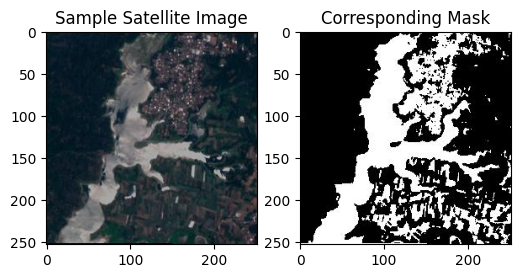

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

sample_image = load_img(image_paths[1])
sample_mask = load_img(label_paths[1])

# Convert the images to numpy arrays and normalize
sample_image_array = img_to_array(sample_image) / 255.0
sample_mask_array = img_to_array(sample_mask) / 255.0

# Display the sample image and mask
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_array)
plt.title('Sample Satellite Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_mask_array)
plt.title('Corresponding Mask')
plt.show()

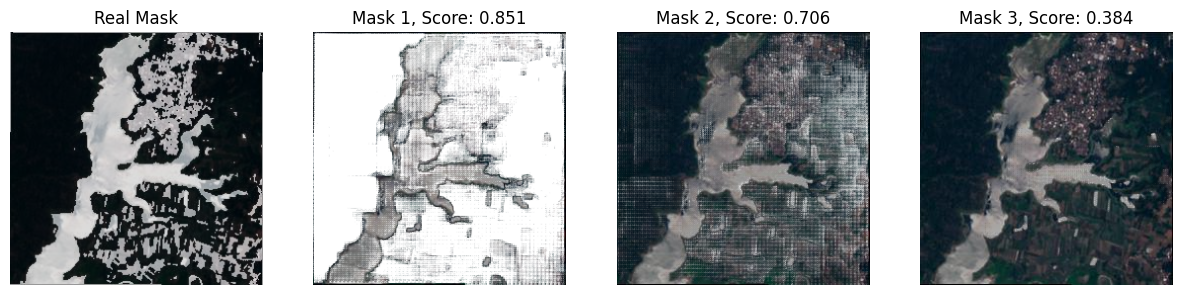

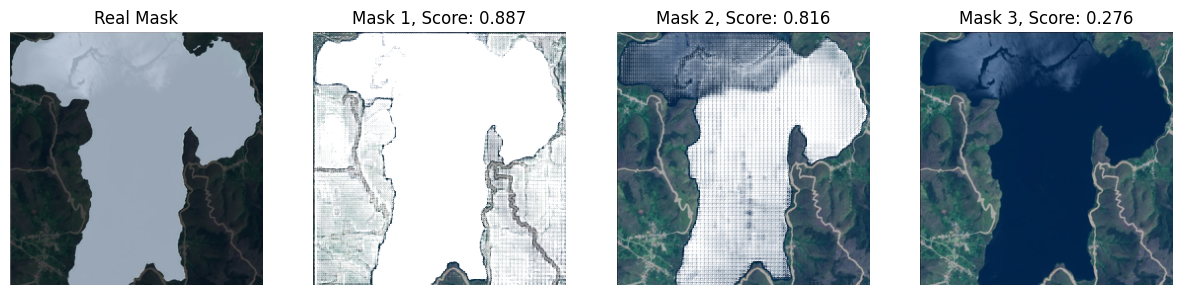

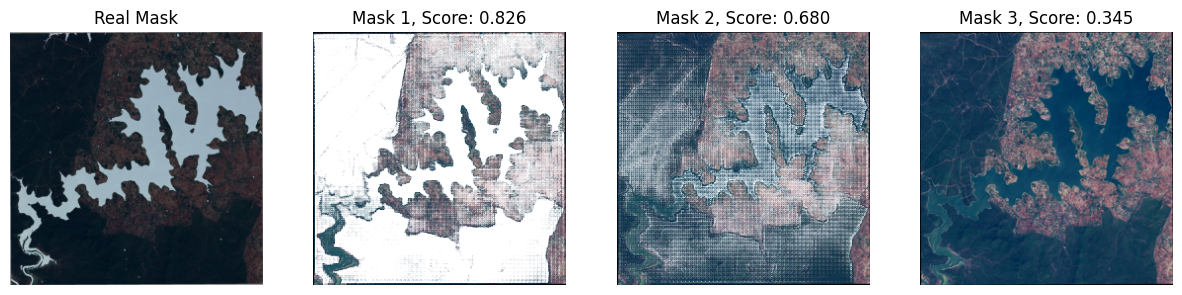

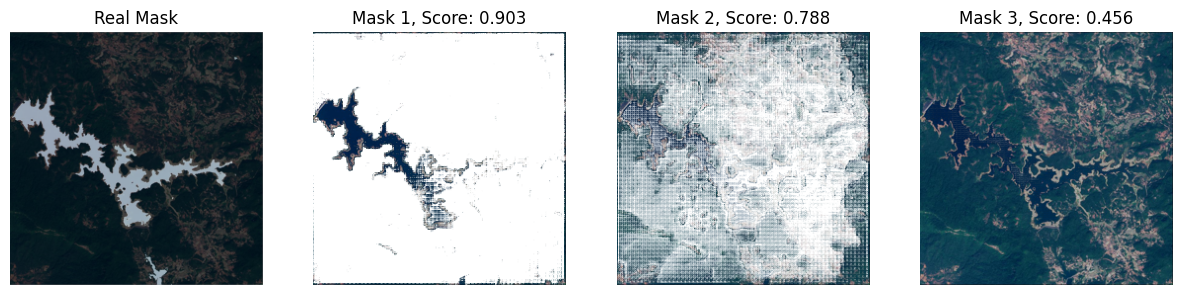

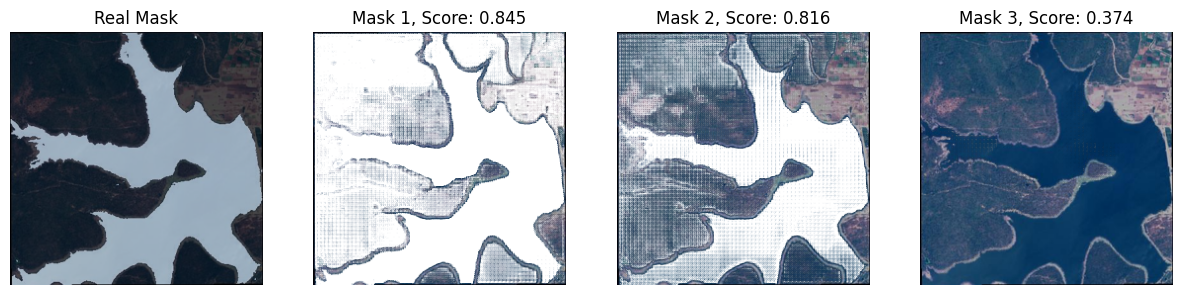

In [ ]:
idxs = [1, 2, 1477, 1484, 1478]

for i in idxs:
    raw_image_inference = Image.open(image_paths[i]).resize((256, 256))
    real_mask_inference = Image.open(label_paths[i]).resize((256, 256))

    # process the image and infer
    preprocessed_img = processor(raw_image_inference)
    outputs = sam(preprocessed_img)
    infer_masks = outputs["pred_masks"]
    infer_mask = infer_masks[0, 0, :, :, :]
    infer_mask = tf.image.resize(infer_mask, [256, 256])

    iou_scores = outputs["iou_scores"]
    show_masks_on_image(raw_image_inference,real_mask_inference, infer_masks, scores=iou_scores)